In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Not strictly used for final SM model but good for local
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb # For local model training and understanding

# SageMaker specific imports
import sagemaker
import boto3
from sagemaker.xgboost.estimator import XGBoost as SageMakerXGBoost # Alias to avoid confusion
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import os # For joining paths
import time # For unique endpoint names

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
try:
    df = pd.read_csv('telco-customer-churn.csv')
    print("Data loaded successfully.")
    print(f"Initial dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'telco-customer-churn.csv' not found. Make sure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

Data loaded successfully.
Initial dataset shape: (7043, 21)


In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"\nMissing values in 'TotalCharges' after conversion to numeric: {df['TotalCharges'].isnull().sum()}")


Missing values in 'TotalCharges' after conversion to numeric: 11


In [4]:
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
    print("Dropped 'customerID' column.")

Dropped 'customerID' column.


In [5]:
if df['TotalCharges'].isnull().any():
    median_total_charges = df[df['tenure'] > 0]['TotalCharges'].median() # Median from customers with tenure
    if pd.isna(median_total_charges) and df['TotalCharges'].isnull().sum() > 0 : # if all are new customers
         median_total_charges = 0 # Fallback if all tenures are 0 or only NaNs exist
    df['TotalCharges'].fillna(median_total_charges, inplace=True)
    print(f"Imputed missing 'TotalCharges' with median: {median_total_charges}")
print(f"Missing values in 'TotalCharges' after imputation: {df['TotalCharges'].isnull().sum()}")

Imputed missing 'TotalCharges' with median: 1397.475
Missing values in 'TotalCharges' after imputation: 0


/tmp/ipykernel_139/3626736219.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(median_total_charges, inplace=True)


In [6]:
if 'Churn' in df.columns:
    if df['Churn'].dtype == 'object': # Check if it needs encoding
        label_encoder_churn = LabelEncoder()
        df['Churn'] = label_encoder_churn.fit_transform(df['Churn'])
        print("'Churn' column encoded to numerical (0 and 1).")
        # To see the mapping: print(dict(zip(label_encoder_churn.classes_, label_encoder_churn.transform(label_encoder_churn.classes_))))
else:
    print("Error: 'Churn' column not found. Cannot proceed with target encoding.")
    exit()

'Churn' column encoded to numerical (0 and 1).


In [7]:
X_features_df = df.drop('Churn', axis=1, errors='ignore') # errors='ignore' if Churn was already dropped or not present
numerical_features = X_features_df.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_features_df.select_dtypes(include='object').columns.tolist()

print("\nNumerical features identified for preprocessing:", numerical_features)
print("Categorical features identified for preprocessing:", categorical_features)


Numerical features identified for preprocessing: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features identified for preprocessing: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [8]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training set shape: X_train=(5634, 19), y_train=(5634,)
Test set shape: X_test=(1409, 19), y_test=(1409,)


In [10]:
# Create preprocessing pipelines for numerical and categorical features
# Numerical features: Scaling
numerical_transformer = StandardScaler()
# Categorical features: One-Hot Encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False) # drop='first' to avoid multicollinearity

# Create a ColumnTransformer to apply transformations
# Ensure feature lists are correct and exist in X_train
current_numerical_features = [col for col in numerical_features if col in X_train.columns]
current_categorical_features = [col for col in categorical_features if col in X_train.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, current_numerical_features),
        ('cat', categorical_transformer, current_categorical_features)
    ],
    remainder='passthrough' # Keep any columns not specified (should ideally be none)
)

# Apply preprocessing: fit on training data, transform both train and test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nShape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of X_test_processed: {X_test_processed.shape}")

# Get feature names after one-hot encoding (for DataFrame conversion and interpretability)
try:
    feature_names_out = preprocessor.get_feature_names_out()
except AttributeError: # Fallback for older scikit-learn versions
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(current_categorical_features)
    feature_names_out = current_numerical_features + list(ohe_feature_names)
    # If remainder='passthrough' and there are remaining columns, their names need to be added.
    # This part can be complex if 'remainder' columns are present and not handled explicitly.

# Convert processed arrays back to DataFrames (optional, but good for local XGBoost and inspection)
if 'feature_names_out' in locals() and feature_names_out is not None and len(feature_names_out) == X_train_processed.shape[1]:
    X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out)
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out)
    print("\nCreated DataFrames from processed data with feature names.")
else: # Fallback if feature names are tricky to get or mismatch
    X_train_processed_df = pd.DataFrame(X_train_processed)
    X_test_processed_df = pd.DataFrame(X_test_processed)
    print("\nCreated DataFrames from processed data (generic column names due to feature name issue).")


Shape of X_train_processed: (5634, 30)
Shape of X_test_processed: (1409, 30)

Created DataFrames from processed data with feature names.



--- Model Training (XGBoost - Local) ---

Local XGBoost Model Evaluation:
Accuracy: 0.7821
ROC AUC Score: 0.8166
Confusion Matrix:
 [[905 130]
 [177 197]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1035
           1       0.60      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:03:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


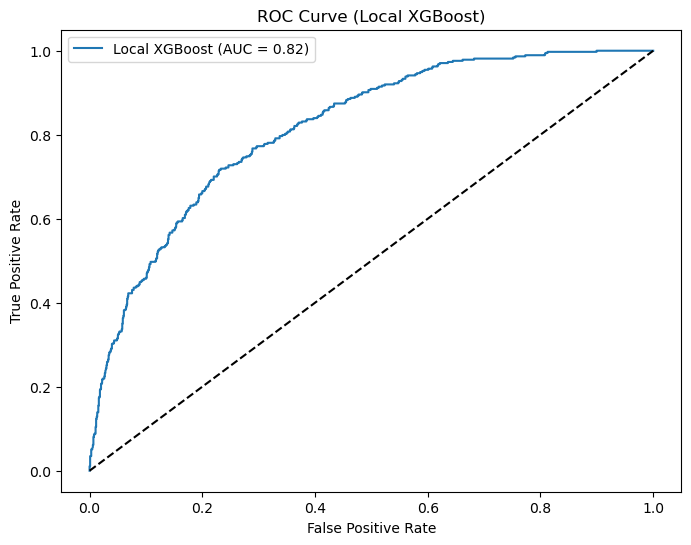

In [11]:
# --- 4. Model Training (XGBoost - Local for demonstration and quick validation) ---
print("\n--- Model Training (XGBoost - Local) ---")
# For newer XGBoost versions (>=1.0), use_label_encoder=False is recommended.
# If you have an older XGBoost, you might need to set it to True or remove it.
local_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', # Common for binary classification
    random_state=42,
    use_label_encoder=False if int(xgb.__version__.split('.')[0]) >= 1 else True
)

local_xgb_model.fit(X_train_processed_df, y_train)

# Make predictions on the local test set
y_pred_local = local_xgb_model.predict(X_test_processed_df)
y_pred_proba_local = local_xgb_model.predict_proba(X_test_processed_df)[:, 1] # Probabilities for the positive class

# Evaluate the local model
print("\nLocal XGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_local):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_local):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_local))
print("Classification Report:\n", classification_report(y_test, y_pred_local))

# Plot ROC Curve for the local model
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_local)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Local XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_local):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Local XGBoost)')
plt.legend()
# plt.show()

In [22]:
print("\n--- SageMaker Setup and Training ---")
sagemaker_execution_successful = False
sagemaker_predictor = None
sagemaker_endpoint_name = None

sagemaker_session = sagemaker.Session()
# IAM role for SageMaker to access AWS resources (e.g., S3)
# This is typically automatically configured in a SageMaker notebook environment.
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()  # SageMaker's default S3 bucket
region = sagemaker_session.boto_region_name

print(f"SageMaker Role ARN: {role}")
print(f"SageMaker S3 Bucket: {bucket}")
print(f"AWS Region: {region}")
# Prepare data for SageMaker's built-in XGBoost algorithm
# It expects CSV format with the target variable in the first column and no headers.
# We use the processed numpy arrays (X_train_processed, X_test_processed) for this.
# Training data: Concatenate y_train (target) and X_train_processed (features)
# Ensure y_train is a column vector for concatenation
train_data_sagemaker_np = np.concatenate((y_train.values.reshape(-1, 1), X_train_processed), axis=1)
# For testing the deployed endpoint, we'll use the preprocessed test features (X_test_processed)
# This numpy array will be serialized to CSV by the predictor.
test_features_sagemaker_np = X_test_processed  # This is what the endpoint will expect

# Define file names for S3 upload
train_file_s3 = 'sagemaker_xgboost_train.csv'
# test_features_file_s3 = 'sagemaker_xgboost_test_features.csv' # Not uploaded, used for local predictor test

# Save the training data to a local CSV file first
pd.DataFrame(train_data_sagemaker_np).to_csv(train_file_s3, header=False, index=False)
print(f"\nPrepared '{train_file_s3}' for SageMaker training.")

# Upload training data to S3
s3_prefix = 'sagemaker/telco-churn-xgboost-demo'  # Define a prefix in your S3 bucket
s3_train_data_path = sagemaker_session.upload_data(path=train_file_s3, bucket=bucket, key_prefix=os.path.join(s3_prefix, 'train'))
print(f"Training data uploaded to S3: {s3_train_data_path}")

# Define SageMaker XGBoost Estimator
# Ensure the XGBoost container version is compatible and available in your AWS region.
# Check AWS SageMaker documentation for the latest supported versions.
xgboost_container_version = '1.7-1'  # Example version, verify its availability
sagemaker_xgboost_image_uri = sagemaker.image_uris.retrieve(
        framework='xgboost',
        region=region,
        version=xgboost_container_version
    )


# S3 path for model artifacts
output_s3_path = f's3://{bucket}/{s3_prefix}/output'

# Instantiate the SageMaker XGBoost estimator
sm_xgb_estimator = SageMakerXGBoost(
    entry_point='',  # Not needed for SageMaker's built-in algorithms
    image_uri=sagemaker_xgboost_image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',  # Choose an appropriate instance type for training
    framework_version="1.7-1",
    output_path=output_s3_path,
    sagemaker_session=sagemaker_session,
    hyperparameters={  # These are examples, tune them for your specific dataset
        'num_round': 100,    # Number of boosting rounds (trees)
    }
)

# Define training input configuration
s3_training_input = sagemaker.inputs.TrainingInput(
    s3_data=s3_train_data_path,
    distribution='FullyReplicated',  # Data is copied to each training instance
    content_type='text/csv',        # Format of the input data
    s3_data_type='S3Prefix'         # S3 URI points to a prefix
)

print("\nStarting SageMaker XGBoost training job... This may take several minutes.")
sm_xgb_estimator.fit({'train': s3_training_input})
print("SageMaker training job completed.")


--- SageMaker Setup and Training ---
SageMaker Role ARN: arn:aws:iam::730335564373:role/cfst-4216-972cf14964d2c97283-SageMakerExecutionRole-C8lSH67KkFhM
SageMaker S3 Bucket: sagemaker-us-east-1-730335564373
AWS Region: us-east-1

Prepared 'sagemaker_xgboost_train.csv' for SageMaker training.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-05-19-14-50-36-567


Training data uploaded to S3: s3://sagemaker-us-east-1-730335564373/sagemaker/telco-churn-xgboost-demo/train/sagemaker_xgboost_train.csv

Starting SageMaker XGBoost training job... This may take several minutes.
2025-05-19 14:50:36 Starting - Starting the training job...
2025-05-19 14:51:03 Starting - Preparing the instances for training...
2025-05-19 14:51:22 Downloading - Downloading input data......
2025-05-19 14:52:13 Downloading - Downloading the training image....[2025-05-19 14:53:15.596 ip-10-2-67-156.ec2.internal:6 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-05-19 14:53:15.621 ip-10-2-67-156.ec2.internal:6 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-05-19:14:53:16:INFO] Imported framework sagemaker_xgboost_container.training
[2025-05-19:14:53:16:INFO] No GPUs detected (normal if no gpus installed)
[2025-05-19:14:53:16:INFO] Running XGBoost Sagemaker in algorithm mode
[2025-05-19:14:53:16:INFO] Determined 0 GPU(s) available on the instan